# Craigslist Capstone Project - Data Wrangling

#### The goal of this capstone is to predict market rent prices in the San Francisco Bay Area. The metros of interest are San Francisco, Peninsula, East Bay. 

Prior to this notebook, the html from craigslist.com rental listings is parsed and saved as a csv file
    * Listing price is the variable we want to predict
    * Listing features include number of bedrooms, bathrooms, address, neighborhood, and optional features provided in `listing_info` and `listing_body` such as whether cats and dogs are allowed, if the rental unit is offered furnished. 
    * Each listing has a unique Listing ID which is set as the index of the dataframe.
    * The listing pages are scraped every 4 days, which means there will be duplicate listings that are exactly the same, and duplicates that are posted over time but are for the same rental unit.


#### This notebook covers the scope of cleaning, transforming and visualizing

1. Drop rows with missing price data and remove duplicate listings
2. Convert data types into appropriate ones for machine learning
3. Clean listing_bathrooms column
4. Clean listing_bedrooms column
5. Filter the listing_sqft column using a chosen min/max
6. Extract listing_info keywords
7. Filter the listing_city column based on how often it occurs
8. Check the metro, neighborhood and listing_city is consistent
9. Add Walk Score, Transit Score and Bike Score data
10. Handle missing values
11. Extract listing_title keywords
12. Extract listing_body into keywords
13. Summarize the data visually


## Importing the libraries

In [216]:
#Run the following once to install libraries needed for Matplotlib to work
#!conda install nomkl numpy scipy scikit-learn numexpr -y
#!conda remove mkl mkl-service -y

In [268]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import re
import requests
import contextlib
import os
import sqlite3
import bs4
from bs4 import BeautifulSoup
import time
import random
# import warnings # For handling error messages. 
# warnings.simplefilter(action="ignore", category=FutureWarning)
# warnings.filterwarnings(action="ignore", module="scipy", message="^internal gelsd")
# from pandas.core.common import SettingWithCopyWarning
# warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)

In [269]:
# Neighborhoods in SF
SFC_NEIGHBORHOODS = ['alamo square / nopa', 'bayview', 'bernal heights', 'castro / upper market', 'cole valley / ashbury hts', 'downtown / civic / van ness',
 'excelsior / outer mission', 'financial district', 'glen park', 'haight ashbury', 'hayes valley', 'ingleside / SFSU / CCSF', 'inner richmond',
 'inner sunset / UCSF', 'laurel hts / presidio', 'lower haight', 'lower nob hill', 'lower pac hts', 'marina / cow hollow', 'mission district',
 'nob hill', 'noe valley', 'north beach / telegraph hill', 'pacific heights', 'portola district', 'potrero hill', 'richmond / seacliff', 'russian hill', 
'SOMA / south beach', 'sunset / parkside', 'tenderloin','treasure island', 'twin peaks / diamond hts', 'USF / panhandle', 'visitacion valley', 
'west portal / forest hill', 'western addition']

# Neighborhoods in Peninsula
PEN_NEIGHBORHOODS = ['atherton','belmont','brisbane','burlingame','coastside/pescadero','daly city','east palo alto','foster city','half moon bay','los altos','menlo park','millbrae',
                     'mountain view','pacifica','palo alto','portola valley','redwood city','redwood shores','san bruno','san carlos','san mateo','south san francisco','woodside']

# Neighborhoods in the East Bay
EBY_NEIGHBORHOODS = ['alameda','albany / el cerrito','berkeley','berkeley north / hills','brentwood / oakley','concord / pleasant hill / martinez','danville / san ramon',
                     'dublin / pleasanton / livermore','emeryville','fairfield / vacaville','fremont / union city / newark','hayward / castro valley','hercules, pinole, san pablo, el sob',
                     'lafayette / orinda / moraga','oakland downtown','oakland east','oakland hills / mills','oakland lake merritt / grand','oakland north / temescal',
                     'oakland piedmont / montclair','oakland rockridge / claremont','oakland west','pittsburg / antioch','richmond / point / annex','san leandro','vallejo / benicia','walnut creek']
# List of cities
SFC_CITIES = ['San Francisco']
PEN_CITIES = ['Palo Alto','San Mateo','Mountain View','Redwood City','Menlo Park','Daly City','San Bruno','South San Francisco','Foster City','Burlingame']
EBY_CITIES = ['Oakland','Berkeley','Fremont','Walnut Creek','Concord','Hayward','Alameda','Pleasanton','San Leandro','Vallejo','San Ramon','Emeryville',
        'Dublin','Richmond','Fairfield','Livermore','Antioch','Pittsburg','Union City','El Cerrito']

ALL_CITIES = SFC_CITIES + PEN_CITIES + EBY_CITIES

# Dictionaries for neighborhood and city relationship
METRO_TO_NEIGHBORHOODS = {'sfc': SFC_NEIGHBORHOODS, 'pen': PEN_NEIGHBORHOODS, 'eby': EBY_NEIGHBORHOODS}
METRO_TO_CITIES = {'sfc': SFC_CITIES, 'pen': PEN_CITIES, 'eby': EBY_CITIES}

NEIGHBORHOOD_TO_METRO = {neighborhood: metro for metro, neighborhoods in METRO_TO_NEIGHBORHOODS.items() for neighborhood in neighborhoods}
CITY_TO_METRO = {city: metro for metro,cities in METRO_TO_CITIES.items() for city in cities}

# Create a dictionary mapping listing_info values to the categorical column name
LISTING_INFO_TO_COLUMN = {'cats are OK - purrr':'animals_cats','dogs are OK - wooof':'animals_dogs','furnished':'furnished',
                    'no smoking':'smoking','wheelchair accessible':'wheelchair accessible','air conditioning':'has_AC',
                     'EV charging':'hasEVCharging','laundry in bldg':'laundry_in_bldg','w/d in unit':'laundry_in_unit',
                     'w/d hookups':'laundry_has_hookup','laundry on site':'laundry_onsite','no laundry on site':'laundry_not_onsite',
                     'carport':'parking_carport','attached garage':'parking_attached_garage','detached garage':'parking_detached_garage',
                     'off-street parking':'parking_offstreet','street parking':'parking_street','valet parking':'parking_valet','no parking':'parking_none',
                     'rent period: daily':'rent_period_daily','rent period: weekly':'rent_period_weekly','rent period: monthly':'rent_period_monthly',
                     'condo':'housing_condo','apartment':'housing_apt','cottage/cabin':'housing_cottage','duplex':'housing_duplex',
                     'flat':'housing_flat','house':'housing_house','in-law':'housing_inlaw','loft':'housing_inlaw','townhouse':'housing_townhouse'}

# Create a dictionary mapping listing_body features to the categorical column name
LISTING_BODY_TO_COLUMN = {'rent control':'is_rent_controlled','no pets':'pets_allowed','remodelled':'is_remodelled',
                         '(amenities)|(pool)|(gym)|(spa)':'has_amenities'}

In [270]:
# Check the metro and neighborhood is consistent
def correct_metro(neighborhood, city):
    if city in CITY_TO_METRO:
        return NEIGHBORHOOD_TO_METRO[neighborhood] == CITY_TO_METRO[city]
    else:
        return False
    
def clean_city(city):
    city = city.strip()
    city = city.strip('.')
    if ',' in city:
        return city.split(',')[0]
    if '/' in city:
        return city.split('/')[0]
    return city

# Extract key features from listing_info
def get_listing_info_feature(listing_info_split, target_info):
    for info in listing_info_split:
        if info == target_info:
            return 1
    return 0

# Extract key features from listing_body
def parse_listing_body(text,target_word):
    for key in LISTING_BODY_TO_COLUMN.keys():
        if re.search(target_word, text.lower()) is not None:
            return 1
    return 0

# Extract key features from listing_title
def parse_listing_title_sqft(text):
    pattern = '(\d+)\s?ft2'
    if re.search(pattern, text.lower()) is not None:
        return int(re.search(pattern, text.lower()).group(1))
    return

## Walkscore scraping

In [271]:
DATABASE = '/Users/pandabear/springboard/CapstoneTwoProject/data/interim/walkscore.db'
HTML_DIRECTORY = '/Users/pandabear/springboard/CapstoneTwoProject/data/interim'
DEBUG = False

def get_walk_score(conn, full_address):
    query = 'SELECT walk_score, transit_score, bike_score FROM walkscore WHERE full_address = ?'
    cur = conn.cursor()
    cur.execute(query, (full_address,))
    row = cur.fetchone()
    if row:
        return (row[0] or None, row[1] or None, row[2] or None,)


def insert_walk_score(conn, full_address, walk_score, transit_score, bike_score):
    query = 'INSERT INTO walkscore (full_address, walk_score, transit_score, bike_score) VALUES (?, ?, ?, ?)'
    cur = conn.cursor()
    cur.execute(query, (full_address, walk_score, transit_score, bike_score,))
    conn.commit()
    
# Add walk score if there is an address
walk_score_root_URL = 'https://www.walkscore.com/score/'
# walk score website url address example format '562-29th-st-oakland'

def get_address_score(conn, address, city):
    full_address = str(address) + " " + str(city)
    full_address = full_address.replace('"','')
    
    # Check address is not np.nan
    if address == np.nan:
        walk_score = None
        transit_score = None
        bike_score = None
        return insert_walk_score(conn, full_address, walk_score, transit_score, bike_score)
    
    # If address is valid, check it is in the walkscore database
    if get_walk_score(conn, full_address):
        return get_walk_score(conn, full_address)
    
    else:
        # Else, scrape the scores from the walkscore website
        address_url = "-".join(str(address).split())
        city_url = "-".join(str(city).split())
        walk_score_url = walk_score_root_URL + address_url + "-" + city_url

    #     print(f'URL of walk score to scrape: {walk_score_url}')
        r = requests.get(walk_score_url)
    #     r.raise_for_status()
        if r.status_code != 200:
            print('Request: {}; Status code: {}'.format(r, r.status_code))
            walk_score = None
            transit_score = None
            bike_score = None
            insert_walk_score(conn, full_address, walk_score, transit_score, bike_score)
            return 

        soup = bs4.BeautifulSoup(r.text, 'html.parser')

        # Get walk score
        div_walk = soup.find("div", {"class": "block-header-badge score-info-link", "data-eventsrc": "score page walk badge"})
        if div_walk == None:
            walk_score = None
        else:
            img_walk = div_walk.findChild('img')
            walk_text_before_regex = img_walk.get('src')
            walk_score = int(re.search('/(\d+)\.svg$', walk_text_before_regex)[1])

        # Get transit score
        div_transit = soup.find("div", {"class": "block-header-badge score-info-link", "data-eventsrc": "score page transit badge"})
        if div_transit == None:
            transit_score = None
        else:
            img_transit = div_transit.findChild('img')
            transit_text_before_regex = img_transit.get('src')
            transit_score = int(re.search('/(\d+)\.svg$', transit_text_before_regex)[1])

        # Get biking score
        div_bike = soup.find("div", {"class": "block-header-badge score-info-link", "data-eventsrc": "score page bike badge"})
        if div_bike == None:
            bike_score = None
        else:
            img_bike = div_bike.findChild('img')
            bike_text_before_regex = img_bike.get('src')
            bike_score = int(re.search('/(\d+)\.svg$', bike_text_before_regex)[1])

    # Add new scores to walkscore database
    insert_walk_score(conn, full_address, walk_score, transit_score, bike_score)
    
    # Add a delay between requests
    time.sleep(random.uniform(1.5, 2.5))

    return walk_score[:1] if DEBUG else [walk_score,transit_score,bike_score]

## Load the data

In [272]:
# The parsed html listing data is the interim directory
dir_folder = '/Users/pandabear/springboard/CapstoneTwoProject/data/interim/'
listing_df = pd.read_csv(dir_folder + 'listing_df.csv',index_col='listing_id')

In [273]:
listing_df.head()

,listing_title,listing_nh,listing_city,listing_date,listing_price,listing_bedrooms,listing_bathrooms,listing_sqft,listing_address,listing_info,listing_body,listing_url,listing_first_image
listing_id,,,,,,,,,,,,,
7518473082,Charming Update Duplex w/Large Yard,burlingame,Burlingame,2022-08-07T10:39:29-0700,2750,1,1,NaN,Oak Grove near Acacia,cats are OK - purrr dogs are OK - wooof dup...,"Large front and back yard, along a quaint neig...",https://sfbay.craigslist.org/pen/apa/d/burling...,https://images.craigslist.org/00k0k_9yaPmYku1l...
7522326058,"Spacious Studio * Minutes to Dining, Shopping!",burlingame,Burlingame,2022-08-16T17:17:40-0700,2500,0,1,NaN,1401 Floribunda Ave,apartment laundry in bldg no smoking attac...,Welcome Home to Classic Peninsula Living at Th...,https://sfbay.craigslist.org/pen/apa/d/burling...,https://images.craigslist.org/00D0D_aFhw5Xkeqe...
7510413512,Where City Living Reaches New Heights Come to ...,daly city,San Francisco,2022-07-18T13:00:26-0700,3450,2,2,1130.0,NaN,application fee details: $39 cats are OK - p...,Highpoint Terrace San Francisco www.highpoints...,https://sfbay.craigslist.org/pen/apa/d/san-fra...,https://images.craigslist.org/00P0P_pHGfLJMzGf...
7526323338,"Wi-Fi in Community Areas, Spacious Open-Concep...",burlingame,Burlingame,2022-08-26T12:02:23-0700,3466,1,1,793.0,1008 Carolan Ave,EV charging cats are OK - purrr dogs are OK...,"Burlingame Spirit, Anson Prestige Brand-New Ap...",https://sfbay.craigslist.org/pen/apa/d/burling...,https://images.craigslist.org/00o0o_bypIwAvRZc...
7503964545,BEAUTIFUL BURLINGAME HOME FOR LEASE!,burlingame,Burlingame,2022-07-02T10:31:55-0700,6500,3,2,1960.0,1711 Marco Polo Way near Clarice,house w/d in unit no smoking attached gara...,"Beautifully remodeled 3 bedroom, 2 bath + sepa...",https://sfbay.craigslist.org/pen/apa/d/burling...,https://images.craigslist.org/00y0y_5q38PKEa4B...


In [274]:
listing_df.describe()

,listing_price,listing_bedrooms,listing_sqft
count,2.212680e+05,221268.000000,184337.000000
mean,4.443034e+03,1.548263,898.748775
std,2.179683e+05,0.917021,1092.700449
min,1.000000e+00,0.000000,1.000000
25%,2.350000e+03,1.000000,656.000000
50%,2.890000e+03,1.000000,800.000000
75%,3.680000e+03,2.000000,1014.000000
max,3.875318e+07,8.000000,94103.000000


In [275]:
listing_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 221268 entries, 7518473082 to 7514097657
Data columns (total 13 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   listing_title        221268 non-null  object 
 1   listing_nh           221268 non-null  object 
 2   listing_city         221268 non-null  object 
 3   listing_date         221268 non-null  object 
 4   listing_price        221268 non-null  int64  
 5   listing_bedrooms     221268 non-null  int64  
 6   listing_bathrooms    221268 non-null  object 
 7   listing_sqft         184337 non-null  float64
 8   listing_address      202946 non-null  object 
 9   listing_info         221268 non-null  object 
 10  listing_body         221268 non-null  object 
 11  listing_url          221268 non-null  object 
 12  listing_first_image  221268 non-null  object 
dtypes: float64(1), int64(2), object(10)
memory usage: 23.6+ MB


In [276]:
listing_dr_rows = listing_df.shape[0]
listing_df.shape

(221268, 13)

In [277]:
listing_df.describe()

,listing_price,listing_bedrooms,listing_sqft
count,2.212680e+05,221268.000000,184337.000000
mean,4.443034e+03,1.548263,898.748775
std,2.179683e+05,0.917021,1092.700449
min,1.000000e+00,0.000000,1.000000
25%,2.350000e+03,1.000000,656.000000
50%,2.890000e+03,1.000000,800.000000
75%,3.680000e+03,2.000000,1014.000000
max,3.875318e+07,8.000000,94103.000000


## 1. Drop rows with missing price data and remove duplicate listings
Drop duplicates using 3 filters: (Note: optional fields in craigslist are address, neighborhood)
* Filter 1: by title, bedroom, bathroom, neighborhood
* Filter 2: by image link, bedroom, bathroom, neighborhood
* Filter 3: by listing_address, listing_city, bedroom, bathroom

In [278]:
# Drop rows that are missing price data
#listing_df = listing_df.dropna(subset=['listing_price'])

# Drop rows where price is below a chosen min and max
price_min = 500
price_max = 20000
listing_df = listing_df.loc[(listing_df.listing_price > price_min) & (listing_df.listing_price < price_max)]

In [279]:
# Look at the number of exact duplicates
duplicates = listing_df['listing_title'].value_counts()
duplicates.head()

First-floor two-bedroom in Theater District                      903
Amazing 2 bed 2 bath home                                        515
***UP to 8-weeks OFF RENT!!*** Apply Today!                      382
Gorgeous 1Bd,1Ba in Newly Renovated Community Downtown Living    232
Renovated 1x1 Apartment with In-Wall USB Charging Ports          221
Name: listing_title, dtype: int64

In [280]:
print('Total number of duplicates by listing title: {}'.format(duplicates[duplicates != 1].sum()))

Total number of duplicates by listing title: 214754


In [281]:
# 1. Drop duplicates by subset of title, bedroom, bathroom, neighborhood
df_drop_by_filter1 = listing_df.drop_duplicates(subset = ['listing_title','listing_bedrooms','listing_bathrooms','listing_nh'], keep = 'last', inplace = False)
print(f"Dataframe size after filter 1: {df_drop_by_filter1.shape[0]} rows, {df_drop_by_filter1.shape[1]} columns")
print(f"Filter 1 dropped {listing_dr_rows - df_drop_by_filter1.shape[0]} rows")

Dataframe size after filter 1: 38688 rows, 13 columns
Filter 1 dropped 182580 rows


In [282]:
# 2. Drop duplicates by subset of image link, bedroom, bathroom, neighborhood
df_drop_by_filter2 = df_drop_by_filter1.drop_duplicates(subset = ['listing_first_image','listing_bedrooms','listing_bathrooms','listing_nh'], keep = 'last', inplace = False)
print(f"Dataframe size after filter 2: {df_drop_by_filter2.shape[0]} rows, {df_drop_by_filter2.shape[1]} columns")
print(f"Filter 2 dropped {df_drop_by_filter1.shape[0] - df_drop_by_filter2.shape[0]} rows")

Dataframe size after filter 2: 26933 rows, 13 columns
Filter 2 dropped 11755 rows


In [283]:
# 3. Drop duplicates by subset of listing_address, listing_city, bedroom, bathroom
df_drop_by_filter3 = df_drop_by_filter2.drop_duplicates(subset = ['listing_address','listing_city','listing_bedrooms','listing_bathrooms'], keep = 'last', inplace = False)
print(f"Dataframe size after filter 3: {df_drop_by_filter3.shape[0]} rows, {df_drop_by_filter3.shape[1]} columns")
print(f"Filter 3 dropped {df_drop_by_filter2.shape[0] - df_drop_by_filter3.shape[0]} rows")

Dataframe size after filter 3: 12469 rows, 13 columns
Filter 3 dropped 14464 rows


In [284]:
# Compare with dropping duplicates based on all columns
df_drop_by_all_cols = listing_df.drop_duplicates(keep = 'last', inplace = False)
df_drop_by_all_cols.shape
print(f"Dataframe size after dropping based on all columns: {df_drop_by_all_cols.shape[0]} rows, {df_drop_by_all_cols.shape[1]} columns")
print(f"Dropping duplicates by all columns dropped {listing_dr_rows - df_drop_by_all_cols.shape[0]} rows")

Dataframe size after dropping based on all columns: 61729 rows, 13 columns
Dropping duplicates by all columns dropped 159539 rows


In [285]:
# Use all 3 filters
df = df_drop_by_filter3
df.head()

,listing_title,listing_nh,listing_city,listing_date,listing_price,listing_bedrooms,listing_bathrooms,listing_sqft,listing_address,listing_info,listing_body,listing_url,listing_first_image
listing_id,,,,,,,,,,,,,
7529193498,"🏠Large Studio close to BART, Caltrain*Private ...",millbrae,Millbrae,2022-09-02T14:32:52-0700,2000,0,1,NaN,Hillcrest Blvd,house no laundry on site no smoking street...,Large lovely studio in the safe convenient lo...,https://sfbay.craigslist.org/pen/apa/d/millbra...,https://images.craigslist.org/00D0D_fhifAAJxNJ...
7530260986,Short term or long term Single Family House,palo alto,Palo alto,2022-09-05T13:28:17-0700,4550,2,2,1200.0,Ely place near Charleston,air conditioning house w/d in unit detache...,Well maintained Single Family House in a sough...,https://sfbay.craigslist.org/pen/apa/d/palo-al...,https://images.craigslist.org/00U0U_g7Jjet53Xo...
7529249759,"Non-smoking 2 Bedroom, 1.5 baths",foster city,Foster City,2022-09-02T17:04:10-0700,3250,2,1.5,980.0,4216 Admiralty Lane near Foster City Blvd/ E. ...,open house dates tuesday 2022-09-06 wedn...,"First, last and security deposit. Two bedroom...",https://sfbay.craigslist.org/pen/apa/d/san-mat...,https://images.craigslist.org/00404_5G4BciZVnU...
7530021597,THIS 1/1 HOME IN PELICAN COVE IS WAITING FOR Y...,redwood city,Redwood City,2022-09-05T00:08:03-0700,3200,1,1,838.0,Pelican Lane near Cove Ln,cats are OK - purrr dogs are OK - wooof apa...,Come home to Pelican Cove! This graceful gro...,https://sfbay.craigslist.org/pen/apa/d/redwood...,https://images.craigslist.org/00C0C_8jvdFt200f...
7530473731,Ultimate 1BR/1BA Condo - 3030 Broderick Street 2,south san francisco,San Francisco,2022-09-06T06:59:16-0700,3689,1,1,900.0,3030 Broderick Street 2,condo laundry in bldg no smoking street pa...,"Capture The Charm, Love The Space, Live The ...",https://sfbay.craigslist.org/pen/apa/d/san-fra...,https://images.craigslist.org/00V0V_6yzLvYtGJn...


## 2. Convert data types

In [286]:
df.dtypes

listing_title           object
listing_nh              object
listing_city            object
listing_date            object
listing_price            int64
listing_bedrooms         int64
listing_bathrooms       object
listing_sqft           float64
listing_address         object
listing_info            object
listing_body            object
listing_url             object
listing_first_image     object
dtype: object

In [287]:
#df.is_copy = False
# Convert the listing_date column into datetime
df.loc[:,'listing_date'] = pd.to_datetime(df['listing_date'])

## 3. Clean listing_bathrooms column
The bathroom category can stay as a categorical feature

In [288]:
# Trim trailing spaces on string values in listing_bathrooms
df.loc[:,'listing_bathrooms'] = df['listing_bathrooms'].map(lambda x: x.strip())
df['listing_bathrooms'].unique()

array(['1', '2', '1.5', '2.5', '3', '4.5', 'split', '3.5', '6', '4',
       'shared', '5', '6.5', '9+', '8', '5.5'], dtype=object)

In [289]:
df['listing_bathrooms'].value_counts()

1         7786
2         2798
1.5        576
2.5        533
3          418
3.5        109
shared      87
split       76
4           52
4.5         18
5            9
6            3
6.5          1
9+           1
8            1
5.5          1
Name: listing_bathrooms, dtype: int64

In [290]:
# 1 split bathroom is the same as 1 bathroom, so convert 'split' to type '1'
df['listing_bathrooms'][df['listing_bathrooms'] == 'split'] = '1'

# Since these are the only inputs for bathroom in the craigslist UI, lump all bathrooms > 3 into a single type '3+'
extra_bath = ['4','4.5','5','5.5','6','6.5','7','7.5','8','8.5','9+']
df['listing_bathrooms'][df['listing_bathrooms'].isin(extra_bath)] = '4+'

In [291]:
df['listing_bathrooms'].value_counts()

1         7862
2         2798
1.5        576
2.5        533
3          418
3.5        109
shared      87
4+          86
Name: listing_bathrooms, dtype: int64

Text(0.5, 1.0, 'Distribution of bathrooms across craigslist listings')

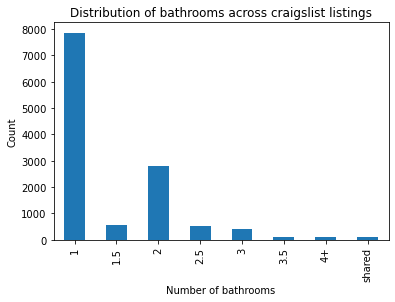

In [292]:
df['listing_bathrooms'].value_counts().sort_index().plot(kind='bar')
plt.xlabel('Number of bathrooms')
plt.ylabel('Count')
plt.title('Distribution of bathrooms across craigslist listings')

## 4. Clean listing_bedrooms column
Consolidate data into categories that belong together e.g. lump 6,7,8 bedroom places into 6+ bedrooms.

The bedroom category can also stay as a categorical feature

In [293]:
# Lump all bedrooms >= 6 into a single type '6+'
extra_bed = ['6', '7', '8']
df.loc[:,'listing_bedrooms'] = df['listing_bedrooms'].astype('str')
df['listing_bedrooms'][df['listing_bedrooms'].isin(extra_bed)] = '6+'
df['listing_bedrooms'].value_counts()

2     4197
1     4106
3     1951
0     1245
4      762
5      161
6+      47
Name: listing_bedrooms, dtype: int64

Text(0.5, 1.0, 'Distribution of bedrooms across craigslist listings')

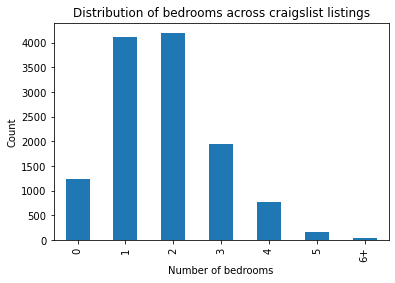

In [294]:
# Look at distributions of number of bedroom data
df['listing_bedrooms'].value_counts().sort_index().plot(kind='bar')
plt.xlabel('Number of bedrooms')
plt.ylabel('Count')
plt.title('Distribution of bedrooms across craigslist listings')

In [295]:
df.shape

(12469, 13)

## 5. Filter the listing_sqft column using a chosen min/max
This will eliminate obvious outliers and wrong inputs

In [296]:
df['listing_sqft'].describe()

count     8528.000000
mean      1064.680582
std       1543.904296
min          1.000000
25%        679.750000
50%        900.000000
75%       1247.000000
max      94103.000000
Name: listing_sqft, dtype: float64

In [297]:
df_rows_before_sqft = df.shape[0]
# If there is a sqft value, drop sqft values that are too small or too big (the 94103 is clearly a zip code)
sqft_min = 200
sqft_max = 30000

df_sqft_transformed = df.listing_sqft.replace('',np.nan)
print(f'The listing_sqft column is missing {df_sqft_transformed.isnull().sum()} rows of data')

df_transformed = df
df_transformed['listing_sqft'] = df_sqft_transformed
df_transformed = df_transformed.loc[(df_transformed.listing_sqft.isnull()) | ((df_transformed.listing_sqft > sqft_min) & (df_transformed.listing_sqft < sqft_max))]
df_rows_after_sqft = df_transformed.shape[0]
print(f'Dropped {df_rows_after_sqft-df_rows_before_sqft} rows that were outside the bounds of the min and max')

The listing_sqft column is missing 3941 rows of data
Dropped -81 rows that were outside the bounds of the min and max


In [298]:
df_transformed['listing_sqft'].describe()

count     8447.000000
mean      1051.391973
std        590.923971
min        208.000000
25%        686.000000
50%        900.000000
75%       1250.000000
max      13000.000000
Name: listing_sqft, dtype: float64

## 6. Extract listing_info keywords
Since these keywords are optional inputs in Craigslist.com, the string varies in length. 
Convert from a string into a list of values that will be converted to their own columns. 

In [299]:
# Convert listing_info from string of values to a list of values
df_transformed['listing_info_split'] = df_transformed['listing_info'].apply(lambda x: x.strip().split("  "))

In [300]:
for target_info, column in LISTING_INFO_TO_COLUMN.items():
    df_transformed[column] = df_transformed['listing_info_split'].apply(lambda x: get_listing_info_feature(x, target_info))

In [301]:
df_transformed.head()

,listing_title,listing_nh,listing_city,listing_date,listing_price,listing_bedrooms,listing_bathrooms,listing_sqft,listing_address,listing_info,...,rent_period_weekly,rent_period_monthly,housing_condo,housing_apt,housing_cottage,housing_duplex,housing_flat,housing_house,housing_inlaw,housing_townhouse
listing_id,,,,,,,,,,,,,,,,,,,,,
7529193498,"🏠Large Studio close to BART, Caltrain*Private ...",millbrae,Millbrae,2022-09-02 14:32:52-07:00,2000,0,1,NaN,Hillcrest Blvd,house no laundry on site no smoking street...,...,0,1,0,0,0,0,0,1,0,0
7530260986,Short term or long term Single Family House,palo alto,Palo alto,2022-09-05 13:28:17-07:00,4550,2,2,1200.0,Ely place near Charleston,air conditioning house w/d in unit detache...,...,0,1,0,0,0,0,0,1,0,0
7529249759,"Non-smoking 2 Bedroom, 1.5 baths",foster city,Foster City,2022-09-02 17:04:10-07:00,3250,2,1.5,980.0,4216 Admiralty Lane near Foster City Blvd/ E. ...,open house dates tuesday 2022-09-06 wedn...,...,0,0,0,0,0,0,0,0,0,0
7530021597,THIS 1/1 HOME IN PELICAN COVE IS WAITING FOR Y...,redwood city,Redwood City,2022-09-05 00:08:03-07:00,3200,1,1,838.0,Pelican Lane near Cove Ln,cats are OK - purrr dogs are OK - wooof apa...,...,0,1,0,1,0,0,0,0,0,0
7530473731,Ultimate 1BR/1BA Condo - 3030 Broderick Street 2,south san francisco,San Francisco,2022-09-06 06:59:16-07:00,3689,1,1,900.0,3030 Broderick Street 2,condo laundry in bldg no smoking street pa...,...,0,1,1,0,0,0,0,0,0,0


## 7. Filter the listing_city column based on how often it occurs
There are some typos in this column because it is a user input.
There are also some cities listed with state and punctuation that should be removed

In [302]:
df_transformed['listing_city'].value_counts()

San Francisco      4101
Oakland            1462
Berkeley            563
San Mateo           247
san francisco       244
                   ... 
San Francisco.        1
San Francisco -       1
Octavia               1
Dearing               1
Oakland CA            1
Name: listing_city, Length: 431, dtype: int64

In [303]:
df_transformed['listing_city'] = df_transformed['listing_city'].apply(lambda x: x.title())
df_transformed['listing_city'] = df_transformed['listing_city'].apply(lambda x: clean_city(x))
df_transformed['listing_city'].value_counts()

# Get index of cities that occur less than 5 times (these are typos or errors)
x = df_transformed['listing_city'].value_counts()
city_to_drop = list((x[x < 5]).index)

# Drop city values that are lower than a value count of 2
df_transformed['listing_city'] = df_transformed['listing_city'].apply(lambda x: None if x in city_to_drop else x)

In [304]:
df_transformed['listing_city'].value_counts().head()

San Francisco    4575
Oakland          1635
Berkeley          612
San Mateo         275
Fremont           263
Name: listing_city, dtype: int64

## 8. Check the metro, neighborhood and listing_city is consistent
Some listings are posted in the wrong metro, or have incorrect neighborhood tags. Drop these rows 

In [305]:
# If a listing has a neighborhood tag, cross reference it with the listing_city to make sure it is in the correct city, otherwise remove from df
df_transformed['is_consistent_metro'] = df_transformed.apply(lambda x: correct_metro(x['listing_nh'], x['listing_city']), axis=1)
df_correct_metro = df_transformed[df_transformed['is_consistent_metro'] == True]

print(f'After checking for consistent metro, dropped {df_correct_metro.shape[0] - df_transformed.shape[0]} rows')
print(f'Database now has {df_correct_metro.shape[0]} rows')

After checking for consistent metro, dropped -1489 rows
Database now has 10899 rows


In [306]:
# Check there are not too many duplicated addresses
df_dup = df_correct_metro["listing_address"].notnull().duplicated()
duplicate_addresses = df_correct_metro[df_dup].groupby('listing_address').listing_title.count().sort_values(ascending=False)
duplicate_addresses[duplicate_addresses > 3]
# The max number of times an address shows up is only 6, which seems reasonable since some are apartment buildings

listing_address
3093 BROADWAY OAKLAND CA 94611 near Piedmont    6
2016 Telegraph Ave near 20th Street             6
3093 Broadway near Piedmont                     6
3900 Adeline Street                             6
1288 E Hillsdale Blvd.                          6
                                               ..
1600 15th St near mission                       4
5421 Campbell Lane near DeMarcus Lane           4
7300 Parkwood Circle                            4
388 Beale Street                                4
1633 Marina Ct                                  4
Name: listing_title, Length: 107, dtype: int64

## 9. Add Walk Score, Transit Score and Bike Score
Use the address to match the corresponding Walk score, Transit score and Bike score


In [307]:
# Add walkscore data if there is an address in the listing
with contextlib.closing(sqlite3.connect(DATABASE)) as conn:
    df_correct_metro['address_score'] = df_correct_metro[['listing_address', 'listing_city']].apply(lambda x: get_address_score(conn, *x), axis=1)

In [308]:
# Separate scores into their own columns
df_correct_metro['walk_score'] = df_correct_metro['address_score'].apply(lambda x: x[0] if x else np.nan)
df_correct_metro['transit_score'] = df_correct_metro['address_score'].apply(lambda x: x[1] if x else np.nan)
df_correct_metro['bike_score'] = df_correct_metro['address_score'].apply(lambda x: x[2] if x else np.nan)

# Remove address_score column
df_correct_metro = df_correct_metro.drop(['address_score'], axis=1)

In [309]:
no_listing_address = len(df_correct_metro['listing_address'].notnull())
missing_walkscore = df_correct_metro['walk_score'].isnull().sum()
missing_transitscore = df_correct_metro['transit_score'].isnull().sum()
missing_bikescore = df_correct_metro['bike_score'].isnull().sum()

print(f"Number of listing addresses: {no_listing_address}")
print(f"Number of missing walk scores: {missing_walkscore}, {missing_walkscore*100/no_listing_address:.1f}% of addresses")
print(f"Number of missing transit scores: {missing_transitscore}, {missing_transitscore*100/no_listing_address:.1f}% of addresses")
print(f"Number of missing bike scores: {missing_bikescore}, {missing_bikescore*100/no_listing_address:.1f}% of addresses")

Number of listing addresses: 10899
Number of missing walk scores: 350, 3.2% of addresses
Number of missing transit scores: 1951, 17.9% of addresses
Number of missing bike scores: 1396, 12.8% of addresses


## 10. Handle missing values

In [310]:
# Missing values in numeric columns
missing = pd.concat([df_correct_metro.isnull().sum(), 100 * df_correct_metro.isnull().mean()], axis=1)
missing.columns=['count', '%']
missing.sort_values(by='count',ascending=False)

,count,%
listing_sqft,3598,33.012203
transit_score,1951,17.900725
bike_score,1396,12.808515
walk_score,350,3.211304
listing_address,329,3.018626
rent_period_monthly,0,0.000000
parking_attached_garage,0,0.000000
parking_detached_garage,0,0.000000
parking_offstreet,0,0.000000
parking_street,0,0.000000


There are about 30% of listing_sqft data missing and 3% of addresses missing.
To handle the missing listing_sqft values: 
1. Try and extract listing_sqft from the title of the craigslist post
2. otherwise in the EDA stage, impute the square footage value with the median value for the given number of bedroom/bathroom combo

To handle the missing address values: the address is used to get the walk score, transit score and bike score.
1. Impute the mean walk score, transit score and bike score for the listing neighborhood

## 11. Extract listing_title keywords

In [311]:
# Use Regex to extract sqft and address information from listing_title for nan values
missing_sqft = df_correct_metro[df_correct_metro.listing_sqft.isnull()][['listing_title','listing_sqft']]

title_sqft = missing_sqft['listing_title'].apply(lambda x: parse_listing_title_sqft(x))
title_sqft = title_sqft[title_sqft.notnull()]

# Join the data on index
df = df_correct_metro.merge(title_sqft, left_index=True, right_index=True, how='left')

# Replace nan values in listing_sqft with values from title_sqft
df.loc[:,'listing_sqft'] = df['listing_sqft'].fillna(df['listing_title_y'])

# Delete the extra columns that are not needed
df = df.drop(['listing_title_y','is_consistent_metro'],axis=1)

# Rename listing_title
df.rename(columns = {'listing_title_x':'listing_title'}, inplace = True)

In [312]:
missing = pd.concat([df.isnull().sum(), 100 * df.isnull().mean()], axis=1)
missing.columns=['count', '%']
missing.sort_values(by='count',ascending=False)

,count,%
listing_sqft,3592,32.957152
transit_score,1951,17.900725
bike_score,1396,12.808515
walk_score,350,3.211304
listing_address,329,3.018626
rent_period_monthly,0,0.000000
parking_attached_garage,0,0.000000
parking_detached_garage,0,0.000000
parking_offstreet,0,0.000000
parking_street,0,0.000000


## 12. Extract listing_body into keywords
The listing_body contains the bulk of the text in a craigslist listing. 
There is a lot of information as text and provides a good summary of the rental unit, but most of the details in the body are already in the feature columns.

Use the dictionary LISTING_BODY_TO_COLUMN to parse the most important details: 
* Is the place rent controlled
* Are pets allowed 
* Has the place been remodelled
* Are there amenities that come with the rental unit e.g. pool, gym, spa


In [313]:
for target_word, column_name in LISTING_BODY_TO_COLUMN.items():
    df[column_name] = df['listing_body'].apply(lambda x: parse_listing_body(x, target_word))

In [314]:
df.head()

,listing_title,listing_nh,listing_city,listing_date,listing_price,listing_bedrooms,listing_bathrooms,listing_sqft,listing_address,listing_info,...,housing_house,housing_inlaw,housing_townhouse,walk_score,transit_score,bike_score,is_rent_controlled,pets_allowed,is_remodelled,has_amenities
listing_id,,,,,,,,,,,,,,,,,,,,,
7495842903,"$1695/1br - Spacious, Furnished Studio on Quie...",palo alto,Palo Alto,2022-06-13 01:02:29-07:00,1695,1,1,400.0,Charleston near Alma,apartment w/d in unit street parking rent ...,...,0,0,0,85.0,46.0,100.0,0,1,0,1
7495966009,"LIVE/WORK/ART LOFT NATURAL SUNLIGHT, INDUSTRIA...",mission district,San Francisco,2022-06-13 08:59:09-07:00,4999,1,1,927.0,555 Florida St. near Mariposa,open house dates thursday 2022-07-28 fri...,...,0,0,0,97.0,83.0,100.0,0,1,0,1
7496082921,"$2,125 Studio! Jingle Town! Welcome To 3030 Ch...",oakland east,Oakland,2022-06-13 12:22:44-07:00,2125,0,1,505.0,3030 Chapman Street near derby,cats are OK - purrr dogs are OK - wooof apa...,...,0,0,0,89.0,72.0,91.0,0,0,0,1
7496092147,Nicely Renovated 2bd/1ba W/New Carpet in Bedro...,oakland east,Oakland,2022-06-13 12:40:39-07:00,2350,2,1,NaN,3050 Fruitvale Ave.,application fee details: Credit Report Check ...,...,0,0,0,83.0,57.0,51.0,0,1,0,1
7496134063,ID#573: Pac Hgts 2BR/1BA Flat w/Pkg & Shared Yd,pacific heights,San Francisco,2022-06-13 14:03:39-07:00,4500,2,1,NaN,Fillmore Street near Jackson Street,apartment laundry in bldg no smoking attac...,...,0,0,0,94.0,82.0,57.0,0,0,0,1


## 13. Summarize the data visually

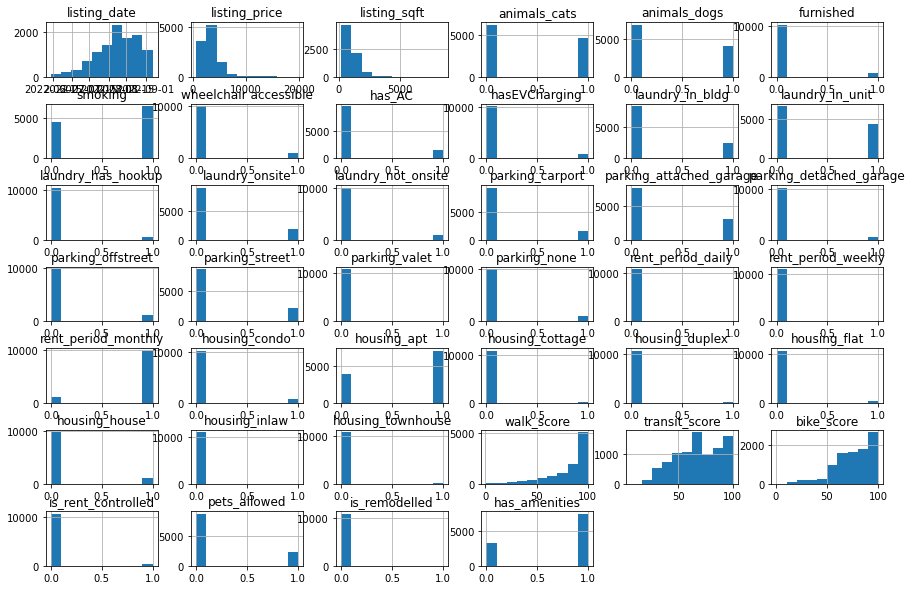

In [315]:
df.hist(figsize=(15,10))
plt.subplots_adjust(hspace=0.5);

In [316]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10899 entries, 7495842903 to 7530536599
Data columns (total 51 columns):
 #   Column                   Non-Null Count  Dtype                                 
---  ------                   --------------  -----                                 
 0   listing_title            10899 non-null  object                                
 1   listing_nh               10899 non-null  object                                
 2   listing_city             10899 non-null  object                                
 3   listing_date             10899 non-null  datetime64[ns, pytz.FixedOffset(-420)]
 4   listing_price            10899 non-null  int64                                 
 5   listing_bedrooms         10899 non-null  object                                
 6   listing_bathrooms        10899 non-null  object                                
 7   listing_sqft             7307 non-null   float64                               
 8   listing_address       

In [317]:
df.to_csv(r'/Users/pandabear/springboard/CapstoneTwoProject/data/interim/listing_df_cleaned.csv', header=True)
print('Saved to csv file')

Saved to csv file


In [318]:
df.shape

(10899, 51)